In [18]:
#MARSS (python)

In [19]:
!pip install nibabel
!pip install shutil
!pip install pandas
!pip install matplotlib
!pip install scipy
# nipype dependencies
!pip install networkx
!pip install numpy
!pip install traits
!pip install python-dateutil
!pip install Sphinx
!pip install traitsui
!pip install nipype[all]
!pip install seaborn 

heloo
You should consider upgrading via the '/mnt/new_jxvs2_02/AshleyWorkspace/myenv/bin/python3 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
You should consider upgrading via the '/mnt/new_jxvs2_02/AshleyWorkspace/myenv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/mnt/new_jxvs2_02/AshleyWorkspace/myenv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/mnt/new_jxvs2_02/AshleyWorkspace/myenv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/mnt/new_jxvs2_02/AshleyWorkspace/myenv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/mnt/new_jxvs2_02/AshleyWorkspace/myenv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/mnt/new_jxvs2_02/AshleyWorkspace/

In [82]:
#function MARSS_getMPs:  used directly in MARSS
import os
import numpy as np
import nibabel as nib
import shutil
import nipype.interfaces.spm as spm
from nipype.interfaces import fsl
#import nipype as spm #does this work instead of above

def MARSS_getMPs(fn, MB, workingDir):
    # Load volume timeseries
    V = nib.load(fn)

    if V.shape[2] % MB != 0:
        raise ValueError(f"Number of slices and MB factor are incompatible for {fn}.")

    p, f = os.path.split(fn)
    f = os.path.splitext(f)[0]

    # Check workingDir for MPs
    mp_path = os.path.join(workingDir, f'rp_{f}.txt')
    if not os.path.exists(mp_path):
        
        mcflt = fsl.MCFLIRT()
        
        mcflt.inputs.in_file = fn
        
        mcflt.inputs.cost = 'mutualinfo'
        
        rp_path = os.path.join(workingDir, "rp_" + f )
        mcflt.inputs.out_file = rp_path

        mcflt.inputs.save_rms = True
        mcflt.inputs.save_plots = True
        # mcflt.inputs.args = "-verbose -1"
        res = mcflt.run()

    # Copy the MP text file to the working directory
    if not os.path.exists(mp_path):
        mp_file_src = os.path.join(p, f'rp_{f}.par')
        mp_file_dst = os.path.join(workingDir, f'rp_{f}.par')
        shutil.copyfile(mp_file_src, mp_file_dst)

    return mp_path


In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.ndimage import rotate
import nibabel as nib

def zToR(z):
    return np.arctanh(z)

def MARSS(timeseriesFile, MB, workingDir):
    # Get name of run
    runName = os.path.splitext(os.path.basename(timeseriesFile))[0]

    # Create a new folder
    runDir = os.path.join(workingDir, runName)
    if not os.path.exists(runDir):
        os.makedirs(runDir)

    # Empty dictionary for all data to go to
    runStruct = {}

    print('Generating pre-MARSS Motion Parameters...')
    # Generate motion parameters for that run and save them
    preMARSS_MPpath = MARSS_getMPs(timeseriesFile, MB, runDir)
    
    # Load motion parameter file and save in DataFrame
    motionParams = pd.read_csv(preMARSS_MPpath)
    runStruct['preMARSS_motionParams'] = motionParams

    print('Generating pre-MARSS Slice Correlations...')
    # Generate slice correlation matrix and save in DataFrame
    preMARSS_corrs = MARSS_mbCorrPlot(timeseriesFile, motionParams, MB)
    preMARSS_sliceCorrelations = {
        'Z_avgSimulSliceCorr_motionRegressed': preMARSS_corrs['rdasimulSlicesZ'],
        'Z_avgAdjacentSliceCorr_motionRegressed': preMARSS_corrs['rdaAdjacentSlicesZ'],
        'R_avgSliceCorrDifference': zToR(preMARSS_corrs['rdasimulSlicesZ'] - preMARSS_corrs['rdaAdjacentSlicesZ']),
        'corrMat_motionRegressed': preMARSS_corrs['corrMat_motionRegressed']
    }
    runStruct['preMARSS_sliceCorrelations'] = pd.DataFrame(preMARSS_sliceCorrelations)
    
    print('Performing MARSS Procedure...')
    # Estimate and remove artifact function
    postMARSS_fname, postMARSS_avgSlcArt_fname = MARSS_removeSliceArtifact(timeseriesFile, MB, motionParams, runDir)
    
    print('Generating post-MARSS Motion Parameters...')
    # Use function to generate motion parameters for new artifact-removed data
    postMARSS_MPpath = MARSS_getMPs(postMARSS_fname, MB, runDir)
    
    # Load new motion parameters and save in DataFrame
    postmotionParams = pd.read_csv(postMARSS_MPpath)
    runStruct['postMARSS_motionParams'] = postmotionParams
    
    print('Generating post-MARSS Slice Correlations...')
    # Generate slice correlation matrix for artifact-removed run and save in DataFrame
    postMARSS_corrs = MARSS_mbCorrPlot(postMARSS_fname, postmotionParams, MB)
    postMARSS_sliceCorrelations = {
        'Z_avgSimulSliceCorr_motionRegressed': postMARSS_corrs['rdasimulSlicesZ'],
        'Z_avgAdjacentSliceCorr_motionRegressed': postMARSS_corrs['rdaAdjacentSlicesZ'],
        'R_avgSliceCorrDifference': zToR(postMARSS_corrs['rdasimulSlicesZ'] - postMARSS_corrs['rdaAdjacentSlicesZ']),
        'corrMat_motionRegressed': postMARSS_corrs['corrMat_motionRegressed']
    }
    runStruct['postMARSS_sliceCorrelations'] = pd.DataFrame(postMARSS_sliceCorrelations)

    # Save final struct 
    sio.savemat(os.path.join(runDir, runName + '_MARSS_SliceCorrelations.mat'), {'runStruct': runStruct})

    # Load avg artifact distribution
    artDistImg = nib.load(postMARSS_avgSlcArt_fname)
    artDistDat = artDistImg.get_fdata()
    maxArt = np.max(artDistDat)
    stdDat = np.std(artDistDat)
    meanArt = np.mean(artDistDat)
    # Color limit for displaying artifact distribution (mean + 3*stddev to control for outlier values)
    colorMax = meanArt + (3 * stdDat)

    # Generate multipanel summary figure
    fig, axs = plt.subplots(2, 6, figsize=(20, 10))

    # Pre-MARSS slice correlation matrix
    axs[0, 0].imshow(runStruct['preMARSS_sliceCorrelations']['corrMat_motionRegressed'], cmap='bwr', vmin=-1, vmax=1)
    axs[0, 0].set_title('Uncorrected Data')
    axs[0, 0].set_xlabel('Slice #')
    axs[0, 0].set_ylabel('Slice #')
    axs[0, 0].axis('equal')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])

    # Post-MARSS slice correlation matrix
    axs[0, 1].imshow(runStruct['postMARSS_sliceCorrelations']['corrMat_motionRegressed'], cmap='bwr', vmin=-1, vmax=1)
    axs[0, 1].set_title('Corrected Data')
    axs[0, 1].set_xlabel('Slice #')
    axs[0, 1].set_ylabel('Slice #')
    axs[0, 1].axis('equal')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])

    # Orthviews of artifact distribution
    axs[0, 2].imshow(rotate(artDistDat[:, :, artDistDat.shape[2]//2], -90), cmap='hot', vmin=0, vmax=colorMax)
    axs[0, 2].axis('off')

    axs[1, 0].imshow(rotate(artDistDat[:, artDistDat.shape[1]//2, :], 180), cmap='hot', vmin=0, vmax=colorMax)
    axs[1, 0].axis('off')

    axs[1, 1].imshow(rotate(artDistDat[artDistDat.shape[0]//2, :, :], 180), cmap='hot', vmin=0, vmax=colorMax)
    axs[1, 1].axis('off')

    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.savefig(os.path.join(runDir, 'MARSS_' + runName + '.png'))
    plt.close(fig)

    print('Completed MARSS for ' + runName + '.')


In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.ndimage import rotate
import nibabel as nib

def MARSS_main(timeseriesFile, MB, workingDir):
    # Get name of run
    runName = os.path.splitext(os.path.basename(timeseriesFile))[0]

    # Create a new folder
    runDir = os.path.join(workingDir, runName)
    if not os.path.exists(runDir):
        os.makedirs(runDir)

    # Empty dictionary for all data to go to
    runStruct = {}

    print('Generating pre-MARSS Motion Parameters...')
    # Generate motion parameters for that run and save them
    preMARSS_MPpath = MARSS_getMPs(timeseriesFile, MB, runDir)
    print(preMARSS_MPpath)

    matrix = text_to_matrix(preMARSS_MPpath)
    
    [postMARSS_fname, postMARSS_avgSlcArt_fname] = MARSS_removeSliceArtifact(timeseriesFile, 6, matrix, workingDir)
    MARSS_mbCorrPlot(postMARSS_fname, matrix, 6)    

In [79]:
MARSS(r"/mnt/new_jxvs2_02/AshleyWorkspace/50017_fMRI_Resting_1_AP.nii", 6, r"/mnt/new_jxvs2_02/AshleyWorkspace/50017MARSS/")

Generating pre-MARSS Motion Parameters...


FileNotFoundError: No such file or directory '/mnt/new_jxvs2_02/AshleyWorkspace/50017MARSS/50017_fMRI_Resting_1_AP/rp_50017_fMRI_Resting_1_AP.nii' for output 'out_file' of a MCFLIRT interface

In [83]:
MARSS_main(r"/mnt/new_jxvs2_02/AshleyWorkspace/50017_fMRI_Resting_1_AP.nii", 6, r"/mnt/new_jxvs2_02/AshleyWorkspace/50017MARSS/")

Generating pre-MARSS Motion Parameters...


FileNotFoundError: No such file or directory '/mnt/new_jxvs2_02/AshleyWorkspace/50017MARSS/50017_fMRI_Resting_1_AP/rp_50017_fMRI_Resting_1_AP' for output 'out_file' of a MCFLIRT interface

In [77]:
MARSS_main(r"/mnt/new_jxvs2_02/AshleyWorkspace/2875_3T_RS_fMRI_1.nii", 6, r"/mnt/new_jxvs2_02/AshleyWorkspace/2875_3T_RS_MARSS/")

Generating pre-MARSS Motion Parameters...


FileNotFoundError: No such file or directory '/mnt/new_jxvs2_02/AshleyWorkspace/2875_3T_RS_MARSS/2875_3T_RS_fMRI_1/rp_2875_3T_RS_fMRI_1.nii' for output 'out_file' of a MCFLIRT interface

In [66]:
import numpy as np

def text_to_matrix(file_path):
    """Converts a text file to a numpy matrix."""

    with open(file_path, 'r') as f:
        lines = f.readlines()

    matrix = []
    for line in lines:
        row = [float(x) for x in line.split()]  # Adjust split() if delimiter is different
        matrix.append(row)

    return np.array(matrix)

matrix = text_to_matrix('/mnt/new_jxvs2_02/AshleyWorkspace/2875_3T_RS_MARSS/2875_3T_RS_fMRI_1/rp_2875_3T_RS_fMRI_1.nii.par')
print(matrix)

[[ 2.37534e-04 -3.40136e-05  2.90133e-04  1.79705e-02  4.99336e-01
   4.34614e-02]
 [ 3.78172e-05  9.73939e-05  2.38787e-04  1.50470e-02  4.90612e-01
   2.55277e-02]
 [ 3.78172e-05 -3.40136e-05  2.38787e-04  1.50596e-02  5.42686e-01
   3.28629e-03]
 ...
 [ 7.03397e-04 -5.68026e-04 -6.66111e-04 -3.40357e-02 -4.93293e-01
  -9.78733e-02]
 [ 7.82253e-04 -3.22828e-04 -3.43683e-04 -3.12812e-02 -5.27427e-01
  -6.06527e-02]
 [ 8.47892e-04 -3.78511e-04 -4.84623e-04 -3.13597e-02 -5.65305e-01
  -4.89212e-02]]


In [70]:
import numpy as np
import nibabel as nib
timeSeriesDat = nib.load(r"/mnt/new_jxvs2_02/AshleyWorkspace/2875_3T_RS_fMRI_1.nii");
timeSeriesDat = timeSeriesDat.get_fdata()
# d = squeeze(mean(mean(nY,1),2))';
d = np.mean(np.mean(timeSeriesDat, axis = 0), axis = 0)
d = d.T
print(d)
# cell not necessary

[[37.56012029 38.91942682 39.37958464 ... 19.05920306 18.38370419
  16.99806915]
 [38.0932823  39.1112549  39.88057604 ... 19.14664681 18.38703685
  16.97388814]
 [38.08198228 38.98756123 39.79586873 ... 19.18075177 18.44186586
  16.99824881]
 ...
 [38.19948129 38.57010474 39.81457259 ... 19.92347136 18.95482031
  17.70490185]
 [37.91249726 38.49905736 40.04904464 ... 19.90696642 18.95795905
  17.70448957]
 [37.79848012 38.80063529 39.98819201 ... 19.88295245 18.94256701
  17.66035919]]


In [53]:
# MARSS_mbCorrPlot.m
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib

def MARSS_mbCorrPlot(fname,MPs,MB):

    timeSeriesDat = nib.load(fname);
    timeSeriesDat = timeSeriesDat.get_fdata()
    # d = squeeze(mean(mean(nY,1),2))';
    d = np.mean(np.mean(timeSeriesDat, axis = 0), axis = 0)
    d = d.T    

    # % nuisance regressor design matrix [intercept, linearDetrend, MPs,squared
    # % MPs, derivatives of MPs, squared derivatives]
    # X = [ones(size(d,1),1) (1:size(d,1))' MPs MPs.^2 [zeros(1,6); diff(MPs)] [zeros(1,6); diff(MPs)].^2];
    intercept = (np.ones((int(d.shape[0]),1)))
    linearDetrend = (np.arange(1, (int(d.shape[0]))+1))
    linearDetrend = linearDetrend[:,np.newaxis]
    MPs_derivatives = np.vstack(((np.zeros(6), np.diff(matrix,axis = 0))))
    squared_MPs_derivatives =  np.vstack((np.zeros(6), np.diff(matrix,axis = 0)))**2 #cannot assign to function call
    X = np.hstack((intercept, linearDetrend,  matrix, matrix**2, MPs_derivatives, squared_MPs_derivatives))
    
    # rd = zeros(size(d));
    rd = np.zeros(d.shape)
    
    # for i = 1:size(d,2)
    #     rd(:,i) = d(:,i) - (X*(X\d(:,i)));
    # end
    for i in range(d.shape[1]):
        # Solve the least-squares problem X \ d[:,i] -> in Python it's np.linalg.lstsq
        beta = np.linalg.lstsq(X, d[:, i], rcond=None)[0]
        
        # Calculate the residual: d[:, i] - X @ beta
        rd[:, i] = d[:, i] - X @ beta
    
    # print(rd)
    
    # out.corrMat_motionRegressed = corr(rd);
    corr = np.corrcoef(rd, rowvar=False) 
    
    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=False, cmap='viridis')
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [ ]:
import os
import pandas as pd

os.getcwd()
print(corr)
# np.savetxt("foo.csv", corr, delimiter=",")
my_df = pd.DataFrame(corr)
my_df.to_csv('/mnt/new_jxvs2_02/AshleyWorkspace/foo.csv', index=False)

In [47]:
import csv
# MARSS_avgMBcorr.m
def MARSS_avgMBcorr(dat, MB):
    c = np.corrcoef(dat, rowvar=False)
    cZ = 0.5 * np.log((1 + c) / (1 - c))
    sgap = c.shape[0] / MB

    # [avgS_Z, avgNS_Z] = deal(zeros(size(c, 1), 1));
    num_rows = c.shape[0]  
    avgS_Z = np.zeros((num_rows, 1))
    avgNS_Z = np.zeros((num_rows, 1))

    # empty array to append ind to 
    rows = []

    for i in range(c.shape[0]):
        cntS = 0;
        cntNS = 0; #where is this used?
        # from i-sgap to 1 in increments of -sgap
        # ind = [(i-sgap):-sgap:1 (i+sgap):sgap:size(c,1)];
        # ind = np.concatenate((np.arange(i - sgap, 0, -sgap), np.arange(i + sgap, num_rows+1, sgap)))
        ind = np.concatenate((np.arange(i - sgap, -1, -sgap), np.arange(i + sgap, num_rows, sgap)))     
        ind = np.array(ind, dtype=int)
        
        # # avgS_Z(i) = mean(cZ(i,ind));
        # avgS_Z[i] = np.mean(cZ[i, ind-1])
        avgS_Z[i] = np.mean(cZ[i, ind])
        
        #adjacent slices
        # ind = [ind-1 ind+1];
        # ind(ind<1|ind>size(c,1)) = [];
        # avgNS_Z(i) = mean(cZ(i,ind));
        ind = np.concatenate((ind - 1, ind + 1))  # Create adjacent indices
        ind = ind[(ind >= 0) & (ind <= num_rows)]  # Keep only valid indices
        # WARNING: THESE CORRELATIONS ARE VERY DIFFERENT THAN THE MATLAB VERSION OF MARSS AS OF NOW
        avgNS_Z[i] = np.mean(cZ[i, ind-1])  # Adjust index for zero-based indexing
    print(np.mean(avgS_Z - avgNS_Z))
    
MARSS_avgMBcorr(rd,6)

NameError: name 'rd' is not defined

In [3]:
# MARSS_estimateSliceArtifact used in MARSS_removeSliceArtifact
from scipy.stats import zscore

def MARSS_estimateSliceArtifact(Y,MB,X):

    # if mod(size(Y,3),MB)
    #     error('# of slices and MB factor are incompatible.');
    # end
    if Y.shape[2] % MB != 0:
        raise ValueError("# of slices and MB factor are incompatible.")
    
    # nSlices = size(Y,3);
    # nSliceSets = nSlices/MB;
    # data = squeeze(mean(mean(Y,1),2))';
    nSlices = Y.shape[2]
    nSliceSets = nSlices // MB
    data = np.squeeze(np.mean(np.mean(Y, axis=1), axis=0)).T
    # print(nSlices, nSliceSets, data)

    # X = zscore(X);
    # X = zscore(X, axis=0, ddof=1) 
    X = zscore(X, axis=0, ddof=1) 
    #print(X)

    # [sameSetData,artifactEstimate,globalSignal] = deal(zeros(size(data)));
    sameSetData = np.zeros_like(data)
    artifactEstimate = np.zeros_like(data)
    globalSignal = np.zeros_like(data)

    for j in range(nSlices):
        sliceSet = j % nSliceSets
        if sliceSet == 0:
            sliceSet = nSliceSets
        
        sameSliceSet = np.zeros(nSlices, dtype=bool)  # Initialize boolean array for same slice set
        lowerSlices = np.arange(sliceSet, j, nSliceSets)  # Get lower slices
        higherSlices = np.arange(j + nSliceSets, nSlices, nSliceSets)  # Get higher slices
        sameSliceSet[np.concatenate((lowerSlices, higherSlices))] = True  # Set slices in the same slice set
    
        # Calculate sameSetData for the current slice j
        sameSetData[:, j] = np.mean(data[:, sameSliceSet], axis=1)
    
        # Exclude current slice from global signal calculation
        sameSliceSet[j] = True
        globalSignal[:, j] = np.mean(data[:, ~sameSliceSet], axis=1)
    
        # Design matrix: [intercept, globalSignal, MPs (X)]
        Xout = np.column_stack((np.ones(data.shape[0]), zscore(globalSignal[:, j],ddof = 1), X))
    
        # Perform the regression (solve the system of equations)
        B = np.linalg.lstsq(Xout, sameSetData[:, j], rcond=None)[0]
    
        # Compute artifact estimate
        artifactEstimate[:, j] = sameSetData[:, j] - Xout @ B
    return [artifactEstimate, globalSignal]


In [71]:
# Xest = [MPs MPs.^2 [zeros(1,6); diff(MPs)] [zeros(1,6); diff(MPs)].^2];
Xest = np.hstack((matrix, matrix**2, MPs_derivatives, squared_MPs_derivatives))

MARSS_estimateSliceArtifact(timeSeriesDat,6,Xest)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 532 and the array at index 2 has size 563

In [59]:
import numpy as np
import nibabel as nib
import os

# MARSS_removeSliceArtifact.m
def MARSS_removeSliceArtifact(filename,MB,MPs,working_dir):
    # V = spm_vol(filename{i});
    # Y = spm_read_vols(V);
    # for j = 1:length(V)
    #     V(j).dt = [16 0];
    # end
    # Y = double(Y);         
    img = nib.load(filename)
    Y = img.get_fdata()
    V = img.header

    # print(img.shape)
    # print(img.affine)
    # print(V.affine)
    
    # Modify the header data type (equivalent to V(j).dt = [16 0])
    # In Nibabel, you modify the datatype using the header object
    hdr = img.header
    hdr.set_data_dtype(np.float32)  # Equivalent to SPM's [16 0] (single precision float)
    # Convert the data to double precision (equivalent to Y = double(Y))
    Y = Y.astype(np.float64)

    # if mod(size(Y,3),MB)
    #     warning(['# of slices and MB factor are incompatible for ' filename{i} '. Skipping.']);
    #     continue
    # end    
    if Y.shape[2] % MB != 0:
        print(f"Warning: # of slices and MB factor are incompatible for {filename}. Skipping.")
        

    MPs = (MPs - np.mean(MPs)) / np.std(MPs)  # Z-score normalization
    # Nuisance parameter design matrix
    Xest = np.hstack([
            MPs,
            MPs ** 2,
            np.vstack([np.zeros((1, 6)), np.diff(MPs, axis=0)]),
            np.vstack([np.zeros((1, 6)), np.diff(MPs, axis=0)]) ** 2
    ])
    
    # Estimate artifact signal in each slice
    [artifactEstimate, nonsliceGlobalSignal] = MARSS_estimateSliceArtifact(Y, MB, Xest)     
    # artifactEstimate = MARSS_estimateSliceArtifact(Y, MB, Xest)     
    # print(artifactEstimate) #doesnt match
    # print(nonsliceGlobalSignal) #matches


    Ya = np.zeros_like(Y)
    Yart = np.zeros_like(Y)   
    for j in range(artifactEstimate.shape[1]):
        # Final MARSS design matrix
        Xcalc = np.column_stack([np.ones(artifactEstimate.shape[0]), (artifactEstimate[:, j] - np.mean(artifactEstimate[:, j])) / np.std(artifactEstimate[:, j]), 
                                 (nonsliceGlobalSignal[:, j] - np.mean(nonsliceGlobalSignal[:, j])) / np.std(nonsliceGlobalSignal[:, j]),
                                 (Xest - np.mean(Xest, axis=0)) / np.std(Xest, axis=0)])

        Yt = Y[:, :, j, :].reshape(-1, Y.shape[3]).T
        # Perform regression
        B = np.linalg.lstsq(Xcalc, Yt, rcond=None)[0]

        # print(Xcalc.shape)
        # print(B.shape)

        # art = Xcalc[:, 1] @ B[1, :]
        # art = np.dot(Xcalc[:,1], B[1,:])
        art = np.outer(Xcalc[:, 1], B[1, :])
        # Subtract artifact estimation from original timeseries data
        # Yta = (Yt.T - art.T).T.reshape(Y.shape[0], Y.shape[1], 1, Y.shape[3])
        # Yartt = art.reshape(Y.shape[0], Y.shape[1], 1, Y.shape[3])
        Y_diff = Yt.T - art.T
        Yta = np.reshape(Y_diff, (Y.shape[0], Y.shape[1], Y.shape[3]))

        Yartt = np.reshape(art.T, (Y.shape[0], Y.shape[1], Y.shape[3]))
        Ya[:, :, j, :] = Yta
        Yart[:, :, j, :] = Yartt

        # Create filenames for output
        base_name = os.path.basename(filename)
        f, x = os.path.splitext(base_name)

    
    for j in range(Y.shape[3]):
        # Corrected Data
        corrected_filename = os.path.join(working_dir, f'za{f}{x}')
        print(V)
        # nib.save(nib.Nifti1Image(Ya[:, :, :, j], img.affine), corrected_filename)
        

        # Isolated artifact timeseries
        artifact_filename = os.path.join(working_dir, f'{f}_slcart{x}')
        # nib.save(nib.Nifti1Image(Yart[:, :, :, j], img.affine), artifact_filename)
    
    nib.save(nib.Nifti1Image(Ya, img.affine), corrected_filename)
    nib.save(nib.Nifti1Image(Yart, img.affine), artifact_filename)
             
    Yaavg = np.mean(np.abs(Yart), axis=3)

    # Average artifact distribution
    avg_artifact_filename = os.path.join(working_dir, f'{f}_AVGslcart{x}')
    nib.save(nib.Nifti1Image(Yaavg, img.affine), avg_artifact_filename)

    postMARSS_fname = os.path.join(working_dir, f'za{f}{x}')
    postMARSS_avgSlcArt_fname = os.path.join(working_dir, f'{f}_AVGslcart{x}')    
        
    return [postMARSS_fname, postMARSS_avgSlcArt_fname]
    

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 16384
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  4  96  96  66 532   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.   2.   2.   2.   0.85 1.   1.   1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 1000.0
cal_min         : 1.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'2203.6-dirty 2022-09-08T15:38:56+01:00')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.038728833
quatern_c       : 0.013593769
quatern_d

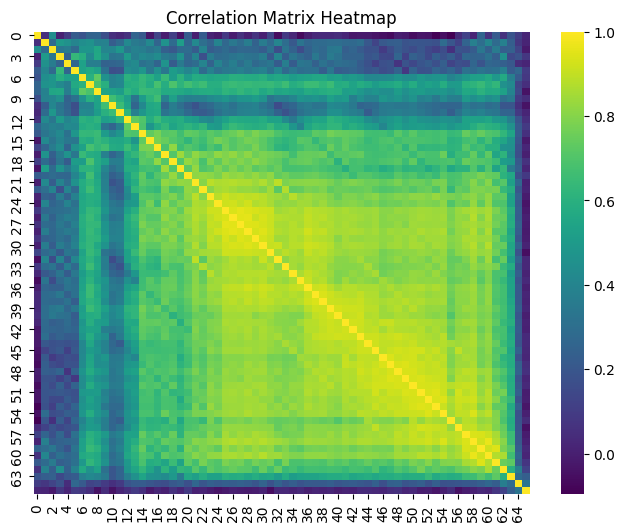

In [73]:
import numpy as np

def text_to_matrix(file_path):
    """Converts a text file to a numpy matrix."""

    with open(file_path, 'r') as f:
        lines = f.readlines()

    matrix = []
    for line in lines:
        row = [float(x) for x in line.split()]  # Adjust split() if delimiter is different
        matrix.append(row)

    return np.array(matrix)

matrix = text_to_matrix('/mnt/new_jxvs2_02/AshleyWorkspace/2875_3T_RS_MARSS/2875_3T_RS_fMRI_1/rp_2875_3T_RS_fMRI_1.nii.par')
# print(matrix)

# print(MARSS_removeSliceArtifact(r"/mnt/new_jxvs2_02/AshleyWorkspace/50017_fMRI_Resting_1_AP.nii", 6, matrix, r"/mnt/new_jxvs2_02/AshleyWorkspace/50017MARSS/"))
# MARSS_removeSliceArtifact(r"/mnt/new_jxvs2_02/AshleyWorkspace/50017_fMRI_Resting_1_AP.nii", 6, matrix, r"/mnt/new_jxvs2_02/AshleyWorkspace/50017MARSS/")
[postMARSS_fname, postMARSS_avgSlcArt_fname] = MARSS_removeSliceArtifact(r"/mnt/new_jxvs2_02/AshleyWorkspace/2875_3T_RS_fMRI_1.nii", 6, matrix, r"/mnt/new_jxvs2_02/AshleyWorkspace/2875_3T_RS_MARSS/")
# MARSS_avgMBcorr(postMARSS_fname,6)
MARSS_mbCorrPlot(postMARSS_fname, matrix, 6)

In [27]:
# MARSS_avgMBcorr(rd,6)
MARSS_avgMBcorr(postMARSS_fname,6)

here
